Inception network was once considered a state-of-the-art deep learning architecture (or model) for solving image recognition and detection problems.
(Inception Layer) is a combination of all those layers (namely, 1×1 Convolutional layer, 3×3 Convolutional layer, 5×5 Convolutional layer) with their output filter banks concatenated into a single output vector forming the input of the next stage.

In [1]:
#!pip install keras==2.1.2

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

''

### Data preparation

In [3]:
from glob import glob
from sklearn.model_selection import train_test_split

Playable = glob('train/zeldaPlayablelevels/*.jpg')
Unplayable = glob('train/zeldaUnplayablelevels/*.jpg')

Playable_train, Playable_test = train_test_split(Playable, test_size=0.30)
Unplayable_train, Unplayable_test = train_test_split(Unplayable, test_size=0.30)

TRAIN_DIR = 'train'
TEST_DIR = 'test'

Plot some random images from the dataset.

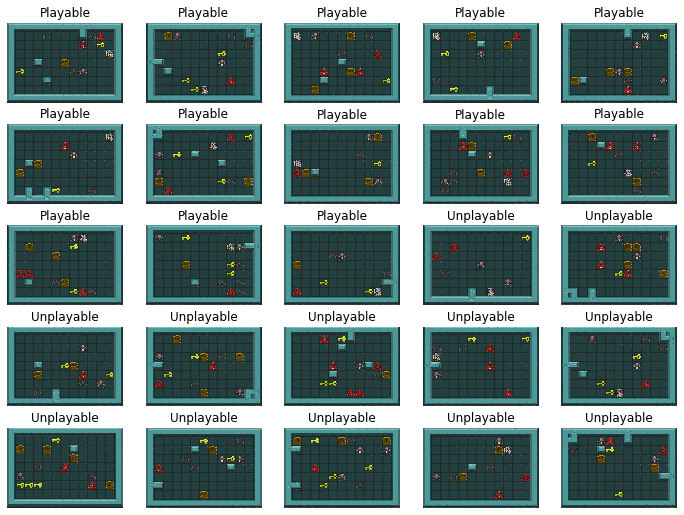

In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Playable = np.random.choice(Playable_train, 13)
Unplayable = np.random.choice(Unplayable_train, 12)
data = np.concatenate((Playable, Unplayable))
labels = 13 * ['Playable'] + 12 *['Unplayable']

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

### Model customization

In [5]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input

CLASSES = 2
    
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.


### Data augmentation

In [6]:
from keras.preprocessing.image import ImageDataGenerator

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 2018 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


Plot some images result of data augmentation.

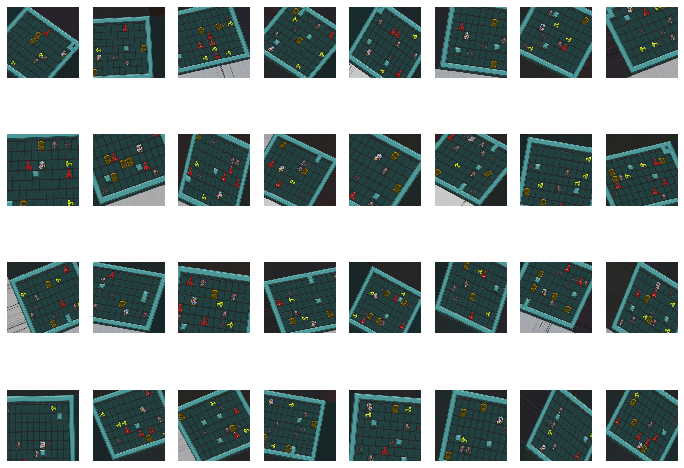

In [7]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

### Transfer learning

In [8]:
EPOCHS = 10
BATCH_SIZE = 32
STEPS_PER_EPOCH = 20
#STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 5

MODEL_FILE = 'inception_adam.model'

history = model.fit_generator(
                            train_generator,
                            epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            validation_data=validation_generator,
                            validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/10
20/20 [==============================] - 558s 28s/step - loss: 0.7979 - accuracy: 0.5066 - val_loss: 0.7594 - val_accuracy: 0.5067
Epoch 2/10
20/20 [==============================] - 519s 26s/step - loss: 0.7624 - accuracy: 0.5188 - val_loss: 0.7225 - val_accuracy: 0.5067
Epoch 3/10
20/20 [==============================] - 450s 22s/step - loss: 0.6966 - accuracy: 0.5875 - val_loss: 0.7191 - val_accuracy: 0.5200
Epoch 4/10
20/20 [==============================] - 437s 22s/step - loss: 0.6923 - accuracy: 0.5738 - val_loss: 0.7489 - val_accuracy: 0.4800
Epoch 5/10
20/20 [==============================] - 452s 23s/step - loss: 0.6759 - accuracy: 0.5859 - val_loss: 0.7024 - val_accuracy: 0.5133
Epoch 6/10
20/20 [==============================] - 452s 23s/step - loss: 0.6806 - accuracy: 0.5906 - val_loss: 0.6518 - val_accuracy: 0.5533
Epoch 7/10
20/20 [==============================] - 437s 22s/step - loss: 0.6630 - accuracy: 0.6098 - val_loss: 0.6695 - val_accuracy: 0.5600
Epoch 

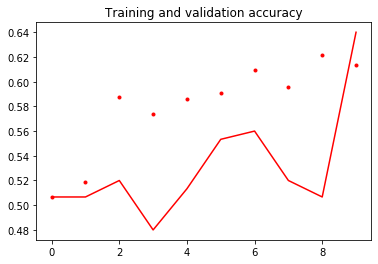

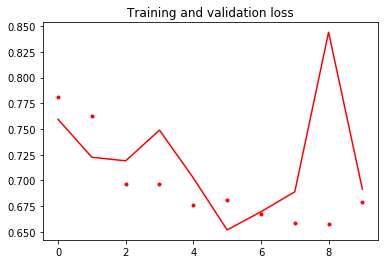

In [9]:
def plot_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

### Prediction of the custom model

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("Playable", "Unplayable")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [11]:
"""from keras.models import Model
from PIL import Image
from keras.preprocessing import image

WIDTH = 299
HEIGHT = 299

MODEL_FILE = 'inception.model'
"""
model = load_model(MODEL_FILE)

array([0.4844007, 0.5155993], dtype=float32)

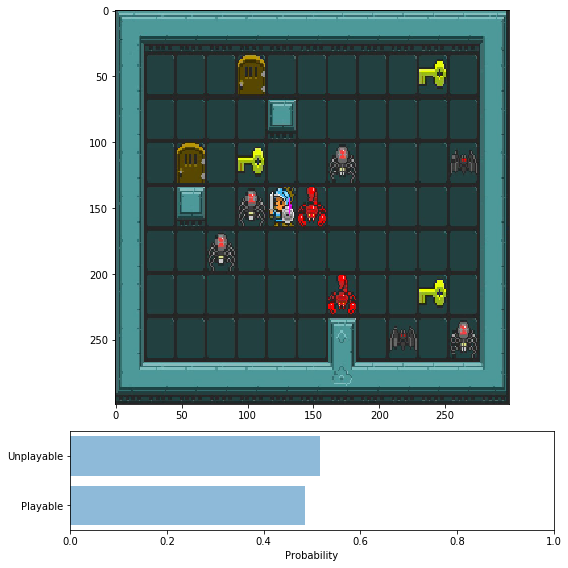

In [12]:
img = image.load_img('test/zeldaPlayablelevels/l1.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [13]:
import numpy
TEST_DIR = 'test'
img_width = 299
img_height = 299

Predict classes

In [14]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    TEST_DIR, # Put your path here
    target_size=(img_width, img_height),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

Found 30 images belonging to 2 classes.


Get ground-truth classes and class-labels

In [15]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   

Use scikit-learn to get statistics

In [16]:
import sklearn.metrics as metrics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

                       precision    recall  f1-score   support

  zeldaPlayablelevels       0.50      1.00      0.67        15
zeldaUnplayablelevels       0.00      0.00      0.00        15

             accuracy                           0.50        30
            macro avg       0.25      0.50      0.33        30
         weighted avg       0.25      0.50      0.33        30



/Users/friends/anaconda3/envs/udacity-ehr-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
